In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.metrics import f1_score,accuracy_score,ConfusionMatrixDisplay,classification_report

In [3]:
normal_dirs = [
    r'C:\project(final new)\test\NORMAL',
    r'C:\project(final new)\train\NORMAL',
    r'C:\project(final new)\val\NORMAL'
 ]
AMD_dirs = [
    r'C:\project(final new)\test\AMD',
    r'C:\project(final new)\train\AMD',
    r'C:\project(final new)\val\AMD'
 ]

file_p = []
labels = []
dict_lists = [normal_dirs, AMD_dirs]
class_labels = ['normal', 'AMD']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
df = pd.DataFrame(data)


In [5]:
df.head()

,filepaths,labels
0,C:\project(final new)\test\NORMAL\normal_test_...,normal
1,C:\project(final new)\test\NORMAL\normal_test_...,normal
2,C:\project(final new)\test\NORMAL\normal_test_...,normal
3,C:\project(final new)\test\NORMAL\normal_test_...,normal
4,C:\project(final new)\test\NORMAL\normal_test_...,normal


labels
normal    3000
AMD       3000
Name: count, dtype: int64


<Axes: ylabel='count'>

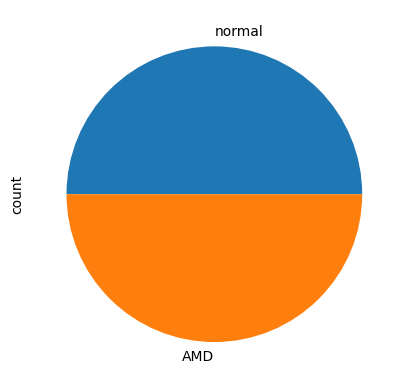

In [7]:
print(df['labels'].value_counts())
df['labels'].value_counts().plot(kind='pie')


In [9]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(3825, 2)
(1500, 2)
(675, 2)


In [11]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    return image

In [13]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image),
)
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                     target_size=(256,256),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3825 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.
Found 675 validated image filenames belonging to 2 classes.


In [15]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

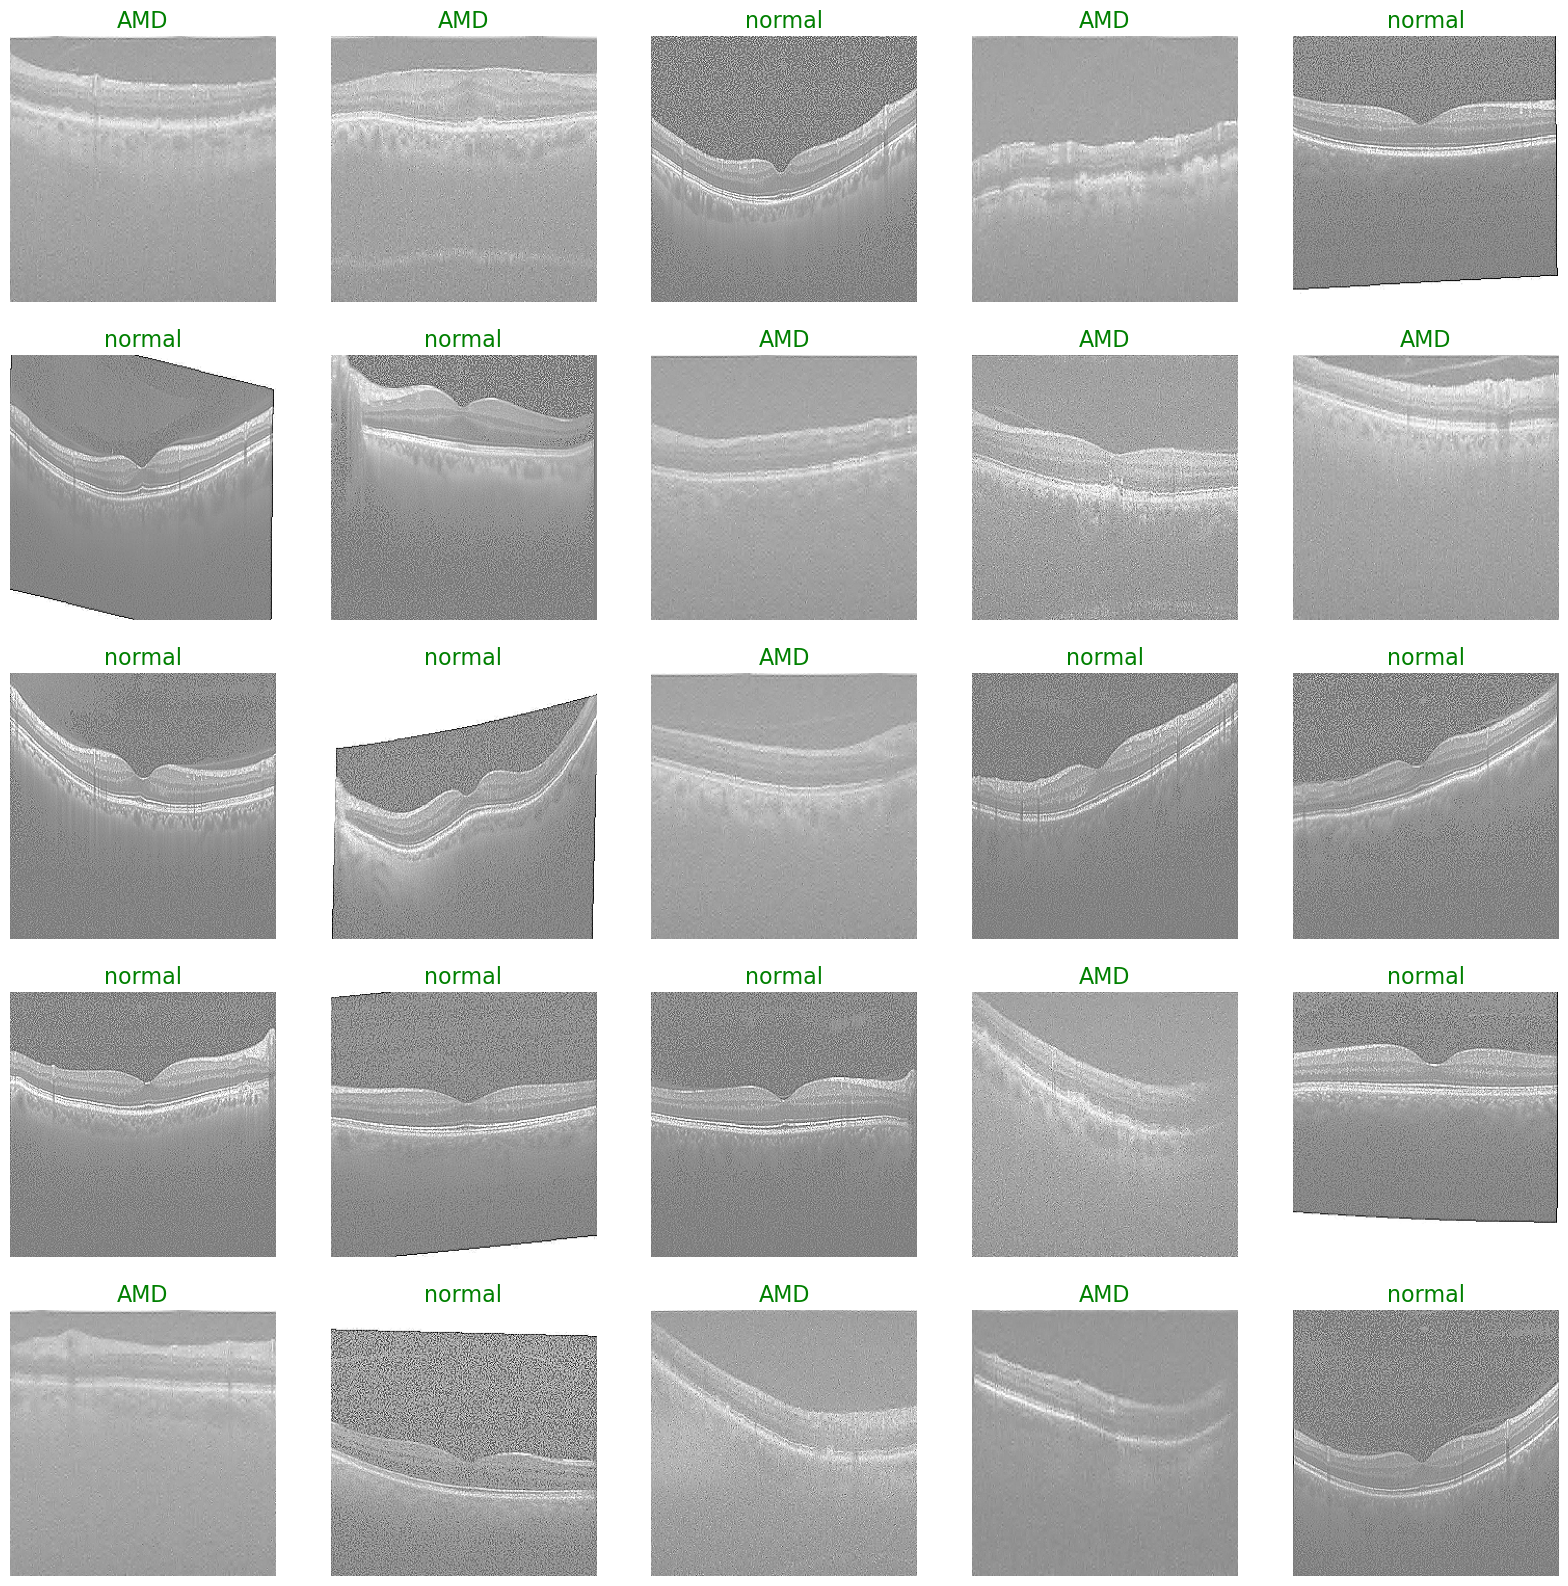

In [17]:
show_images(train)

In [19]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=256, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='selu'),
    keras.layers.Dense(2, activation='softmax')
])

C:\Users\Rashmitha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 83, 83, 256)         │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 83, 83, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 83, 83, 256)         │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 83, 83, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 128)         │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 27, 27, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,384,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,478,242 (13.27 MB)

 Trainable params: 3,476,450 (13.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [23]:
history = model.fit(train, epochs=4, validation_data=val)

Epoch 1/4


C:\Users\Rashmitha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 3566s 30s/step - accuracy: 0.9158 - loss: 0.3186 - val_accuracy: 0.4785 - val_loss: 3.4383
Epoch 2/4
120/120 ━━━━━━━━━━━━━━━━━━━━ 3483s 29s/step - accuracy: 0.9974 - loss: 0.0056 - val_accuracy: 0.4785 - val_loss: 3.6770
Epoch 3/4
120/120 ━━━━━━━━━━━━━━━━━━━━ 3494s 29s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.4993 - val_loss: 2.0987
Epoch 4/4
120/120 ━━━━━━━━━━━━━━━━━━━━ 2417s 20s/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9422 - val_loss: 0.1302


In [25]:
# Save model in Keras format (.keras)
model.save("new_amd_detection_model.keras")
print("Model saved successfully as new1_amd_detection_model.keras")


Model saved successfully as new1_amd_detection_model.keras


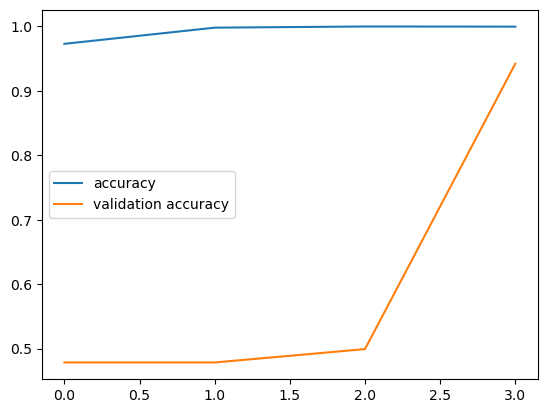

In [27]:
plt.plot(history.history['accuracy'],label = 'accuracy')
plt.plot(history.history['val_accuracy'],label = 'validation accuracy')
plt.legend()

In [31]:
model.evaluate(test)

C:\Users\Rashmitha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.9379 - loss: 0.1268


[0.12997418642044067, 0.9419999718666077]

In [32]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 188s 4s/step


In [37]:
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [39]:
y_test = test_df.labels 

Accuracy of test data ||||| 0.942
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
              precision    recall  f1-score   support

         AMD       0.89      1.00      0.94       731
      normal       1.00      0.89      0.94       769

    accuracy                           0.94      1500
   macro avg       0.95      0.94      0.94      1500
weighted avg       0.95      0.94      0.94      1500

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


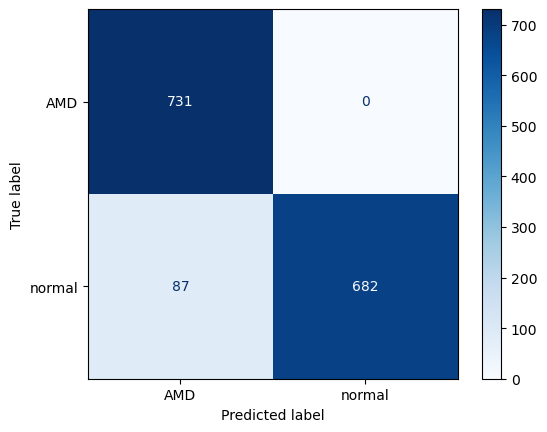

In [41]:
print(f'Accuracy of test data ||||| {accuracy_score(y_test,pred)}')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(f'{classification_report(y_test,pred)}')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
ConfusionMatrixDisplay.from_predictions(y_test,pred,cmap='Blues')